* Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Or, alternatively, **Restart & Run All**.

* Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

* You can always add additional cells to the notebook to experiment, to test your answers, or to provide additional support for your answers.

* You should not need to install new packages to complete an assignment. If you use any packages not available via the MATH405 `Project.toml` then your assignment will likely not be graded correctly.

* Submissions are only accepted via CANVAS!

* Late submissions: within 24h I will reduce the grade to 70%. I will not accept submissions after 24h. Please manage your time well and complete the assignments with plenty of buffer time.

* By entering your name below you confirm that you have completed this assignment on your own and without (direct) help from your colleagues. Plagiarism / copying will be checked by comparing assignments and by by testing understanding in workshops and the oral exam (final). I reserve the option to downgrade an assignment at any point.

In [2]:
NAME = "Owen Sheekey"

"Owen Sheekey"

---

# MATH 405/607 

# Numerical Methods for Differential Equations

## Assignment 2: Nonlinear systems, interpolation, quadrature


#### Notes

* I will start to be rigorous about following instructions precisely to enable the autograder to correctly read you answers. Please watch out for those instructions. If a solution is correct but is not stored in the correct variables I will only give partial points. 
* **Due date:** Wed 14 October 2020, 1200 noon
* 90 points (out of 125) will count for 100%

In [1]:
include("math405.jl")

 Activating environment at `~/Documents/UBC/Math/Math 405/math405_2020W/assignments/A2/Project.toml`


### Question 1 [5+5]

Skim the `README` files of [`Roots.jl`](https://github.com/JuliaMath/Roots.jl) and of [NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl) to understand what these packages are written for. Then use appropriate functions provided by these packages to solve the following nonlinear equations: 

(a) Find all solutions $x \in [0.1, 4.1\pi]$ of 
$$
    x^{-2} = \sin(x)
$$
Assign these to a vector as follows: `X_a = [ x1, x2, ... ]`

(b) Find the unique solution of the system  
$$\begin{aligned}
    & f(x) := \nabla \varphi(x) = 0,  \qquad \text{where} 
    & \varphi(x) = x_1^6 + \sum_{j = 2}^{10} (x_j - x_{j-1})^6 + x_{10}^6 -0.01 \sum_{j = 1}^{10} x_j.
\end{aligned}$$
and store it in the variable `xb` i.e. 

HINT: you need not derive and implement the gradient, but could use an AD package (e.g. `ForwardDiff.jl`) to obtain it from $\varphi$, e.g., 
```julia 
fb(x) = ForwardDiff.gradient(phi, x)
```

In [3]:
# Somewhere in this code you should have the lines 
#  Xa = [ ... ]
#  xb =  ...

# YOUR CODE HERE
# Starting with part (a)
# Define the lower and upper bounds
bounds = [0.1 4.1*pi]

# We would like to find roots of this function on the interval
g(x) = sin(x) - x^(-2)

# Plug and chug
Xa = find_zeros(g, bounds[1], bounds[2])
@show Xa

# Now looking at part (b)
# Lets start with defining the function
φ(X) = X[1]^6 + X[10]^6 + sum([(X[j]-X[j-1])^6 for j=2:10]) - 0.01*sum(X)

function gradφ(X)
    return ForwardDiff.gradient(φ, X)
end

# Generate a random starting point (maybe there is a better way of doing this)
initialX = rand(10)

# Using NlSolve
xb = nlsolve(gradφ, initialX)
@show xb

Xa = [1.068223544197249, 3.032645418388756, 6.308316825268553, 9.413492803170099, 12.572696859373606]
xb = Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.5881470953920964, 0.5219033657355852, 0.8046094881835304, 0.08917490359015878, 0.7851892922010537, 0.6413151317448307, 0.35789795319903983, 0.8314074011813974, 0.7874041511781407, 0.08485950591127178]
 * Zero: [0.3838519496373775, 0.7509497212223628, 1.097522142799936, 1.4170993146379969, 1.6953074015982368, 1.69530740159848, 1.4170993146380024, 1.0975221427999382, 0.7509497212223637, 0.3838519496373776]
 * Inf-norm of residuals: 0.000000
 * Iterations: 32
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 31
 * Jacobian Calls (df/dx): 16


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.5881470953920964, 0.5219033657355852, 0.8046094881835304, 0.08917490359015878, 0.7851892922010537, 0.6413151317448307, 0.35789795319903983, 0.8314074011813974, 0.7874041511781407, 0.08485950591127178]
 * Zero: [0.3838519496373775, 0.7509497212223628, 1.097522142799936, 1.4170993146379969, 1.6953074015982368, 1.69530740159848, 1.4170993146380024, 1.0975221427999382, 0.7509497212223637, 0.3838519496373776]
 * Inf-norm of residuals: 0.000000
 * Iterations: 32
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 31
 * Jacobian Calls (df/dx): 16

### Question 2 [10+5+10]

Newton's method is chaotic (cf Fractals) and in general converges only locally, or at least its global behaviour is unpredictable for most practical purposes. Most implementations of Newton's method therefore have some "globalisation" strategies, i.e. incorporate ideas (heuristic and rigorous) to improve global convergence properties, or at least increase make the behaviour more predictable. In this question we will explore one strategy of this kind. 

Suppose your current iterate is $x_n$ then the next iterate would be $x_{n+1} = x_n - \partial f(x_n)^{-1} f(x_n)$. But instead, let us define this increment as a *search vector*. That is, we define 
$$
    p_n := - \partial f(x_n)^{-1} f(x_n)
$$
and look for updates of the form 
$$
    x_{n+1} = x_n + \alpha_n p_n
$$
where $\alpha_n \in (0, 1]$.

(a+) Compute $\frac{d}{d\alpha} |f(x_n + \alpha p_n)|^2$ at $\alpha = 0$, then deduce that, for sufficiently small $\alpha$ the update $x_{n+1}$ satisfies
$$
  \text{(DEC)} \qquad   |f(x_{n+1})| \leq (1 - \alpha_n/2) |f(x_n)|
$$
You may use any regularity on $f$ that you need.

Remarks:
* In your proof you should find that the factor $1/2$ in $(1-\alpha/2)$ is somewhat arbitrary. But it is a sensible choice that seems to work quite well in the following tests.
* You can proceed to part (b) without answering this question.

To compute $\frac{d}{d\alpha} |f(x_n + \alpha p_n)|^2$ at $\alpha = 0$, let $\tilde x_n = x_n + \alpha p_n$. Then
$$
    \frac{d}{d\alpha} |f(x_n + \alpha p_n)|^2 = \frac{d\tilde x_n}{d\alpha}\frac{d}{d\tilde x_n}|f(x_n + \alpha p_n)|^2
$$
We can work this out noting that $\frac{d\tilde x_n}{d\alpha} = p_n$ and that $p_n := - \partial f(x_n)^{-1} f(x_n)$
$$
    \frac{d\tilde x_n}{d\alpha}\frac{d}{d\tilde x_n}|f(x_n + \alpha p_n)|^2 = 2p_n \partial f(\tilde x_n) f(\tilde x_n) \\
    \text{@ } \alpha = 0 \implies -2 |f(x_n)|^2
$$

Next, define $g(\alpha) = |f(x_n + \alpha p_n)|^2$ and note that by definition, $f(x_n + \alpha p_n) = f(x_{n+1})$. Then, we can Taylor expand $g(\alpha)$ about $\alpha = 0$ as such
$$
    g(\alpha) = |f(x_n + \alpha p_n)|^2 = |f(x_{n+1}|^2 = g(0) + (\alpha - 0)g'(0) + O(\alpha^2) \\
    \leq |f(x_n)|^2 - 2\alpha |f(x_n)|^2  = |f(x_n)|^2 (1 - 2\alpha)
$$
Therfore, since $\alpha$ is non-negative, $\sqrt{1-2\alpha} < (1 - \alpha/2)$
$$
    |f(x_{n+1}| \leq |f(x_n)| \sqrt{1-2\alpha} \\
    \implies |f(x_{n+1}| \leq |f(x_n)| (1 - \alpha/2)
$$

(b) To achieve the (DEC) condition, we can use a backtracking algorithm. At each iterate $x_n$ our first guess should be $\alpha = 1$ to obtain quadratic convergence in the limit. If this fails the (DEC) condition, then we halve $\alpha$ until it is satisfied.
``` 
WHILE ||f(x + alpha p)|| > (1-alpha/2) * ||f(x)||
    alpha <- alpha / 2
```
* Implement this backtracking condition into a Newton iteration. 
* In light of part (a) of this question, terminate the backtracking with `return nothing` when $\alpha < 10^{-8}$.

In the code-cell below most of the two Newton methods have already been written. Only edit the part of the code that is indicated to incorporate the backtracking loop. Just translate the pseudocode into valid Julia code.

In [4]:

function newton(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 10)
    x = x0 
    it = 0
    while norm(f(x)) > tol 
        x -= df(x) \ f(x)
        it += 1; 
        if (it > maxiter) || any(isnan, x) || any(isinf, x)
            return nothing
        end
    end 
    return x, it 
end

function damped_newton(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 100)
    x = x0
    it = 0

    while norm(f(x), Inf) > tol 
        p = - (df(x) \ f(x))
        
        # --------- Backtracking loop 
        # YOUR CODE HERE
        α = 1
        while(norm(f(x + α * p)) > (1 - α/2) * norm(f(x)))
            if α < 1e-8; return nothing; end 
            α = α/2
        end
        
        x += α * p
        it += 1

        # for debugging!
        # @show α, norm(f(x), Inf)    

        if it > maxiter; return nothing; end 
    end
    return x, it 
end

damped_newton (generic function with 2 methods)

 This little test shows how Newton's method can converge 
 predictably or to vastly different solution
 while the damped Newton method usually converges predictably.
    
 Check that the damped Newton method always converges to the 
 root near 6.38.

Newton - Start guess 4.85:
   x = [6.380161895923983], #it = 7
Newton - Start guess 4.84:
   x = [28.90835078092175], #it = 7
Damped Newton - Start guess 4.85:
   x = [6.380161895923983], #it = 4
Damped Newton - Start guess 4.84:
   x = [6.380161895923983], #it = 4


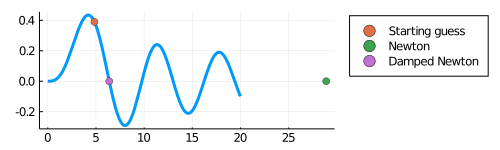

In [5]:
# you may edit this cell to experiment with your code ...

println("""
 This little test shows how Newton's method can converge 
 predictably or to vastly different solution
 while the damped Newton method usually converges predictably.
    
 Check that the damped Newton method always converges to the 
 root near 6.38.
""")

# wrapping a scalar problem into a vectorial one (with 1 dimension of course...)
fbes = x -> [besselj(3,x[1])]

println("Newton - Start guess 4.85:")
xn1, itn1 = newton(fbes, [4.85], 1e-10)
println("   x = $(xn1), #it = $(itn1)")

println("Newton - Start guess 4.84:")
xn2, itn2 = newton(fbes, [4.84], 1e-10)
println("   x = $(xn2), #it = $(itn2)")

println("Damped Newton - Start guess 4.85:")
xd1, itd1 = damped_newton(fbes, [4.85], 1e-10)
println("   x = $(xd1), #it = $(itd1)")

println("Damped Newton - Start guess 4.84:")
xd2, itd2 = damped_newton(fbes, [4.84], 1e-10)
println("   x = $(xd2), #it = $(itd2)")

plot(x->besselj(3,x), 0, 20, lw=3, label="", grid=:xy, size=(500,150), legend = :outertopright)
scatter!([4.84], fbes(4.84), label = "Starting guess")
scatter!(xn2, [0.0], label = "Newton")
scatter!(xd2, [0.0], label = "Damped Newton")

(c) Use both the Newton and damped Newton algorithms to solve the problem from Question 1, with starting guess `x0[i] = c * i * (11-i)` where `c in [0.01, 0.1]` and briefly comment on your observations. Use comments such as ,
```julia 
# we oberserve that `newton` ... while `damped_newton` ... 
```

(itn1, itd1) = (16, 7)
    We can note that in fact, the damped newton method takes fewer iterations than the Newton method. 
    We might naively expect Newton's method to converge faster, but clearly this is not what happens
    At first, I thought the fact that the damped method converges to the closest minima gives it an advantage 
    in converging in fewer iterations. But that can't be the case since we can check this by looking at the 
    ||output - x0|| for each case to see if they converged on the same minima.

(norm(xn1 - x0), norm(xd1 - x0)) = (0.41144971531235563, 0.41144971528286983)
    So they converge on the same point, the other thought is maybe Newton's method is doing a lot of 'bouncing'
    around - going too far then, overcompensating to come back. We could easily check that by looking a plot of 
    ||currguess - x0|| at each iteration.

    
    
    
    I think this plot tells me that my logic was correct, though maybe its not very clear. What I see is that ri

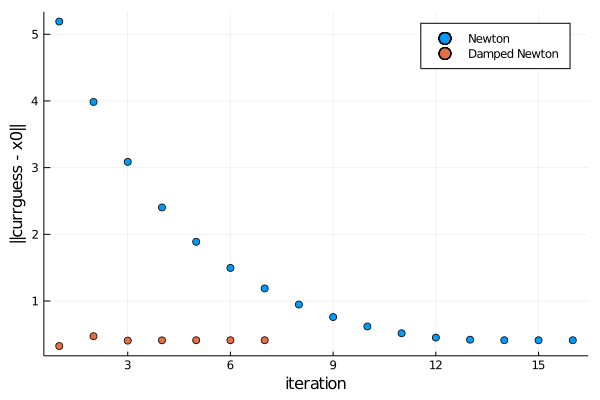

In [6]:
# Compute starting guess
c = 0.05
x0 = [c * i * (11-i) for i = 1:10]

# Calling Newton
xn1, itn1 = newton(gradφ, x0, 1e-10, maxiter=100)

xd1, itd1 = damped_newton(gradφ, x0, 1e-10, maxiter=100)

@show itn1, itd1

println("""
    We can note that in fact, the damped newton method takes fewer iterations than the Newton method. 
    We might naively expect Newton's method to converge faster, but clearly this is not what happens
    At first, I thought the fact that the damped method converges to the closest minima gives it an advantage 
    in converging in fewer iterations. But that can't be the case since we can check this by looking at the 
    ||output - x0|| for each case to see if they converged on the same minima.
""")
@show norm(xn1 - x0), norm(xd1 - x0)
println("""
    So they converge on the same point, the other thought is maybe Newton's method is doing a lot of 'bouncing'
    around - going too far then, overcompensating to come back. We could easily check that by looking a plot of 
    ||currguess - x0|| at each iteration.
""")

# Just making an alternate version of the two functions that does ||currguess - x0|| at each iteration

function newton_plot(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 10)
    x = x0 
    it = 0
    dists = []
    
    while norm(f(x)) > tol 
        x -= df(x) \ f(x)
        it += 1; 
        if (it > maxiter) || any(isnan, x) || any(isinf, x)
            return nothing
        end
        append!(dists, [norm(x - x0)])
    end 
    return x, it, dists
end

function damped_newton_plot(f, x0, tol, df = x -> ForwardDiff.jacobian(f, x); maxiter = 100)
    x = x0
    it = 0
    dists = []
    while norm(f(x), Inf) > tol 
        p = - (df(x) \ f(x))
        
        # --------- Backtracking loop 
        # YOUR CODE HERE
        α = 1
        while(norm(f(x + α * p)) > (1 - α/2) * norm(f(x)))
            if α < 1e-8; return nothing; end 
            α = α/2
        end
        
        x += α * p
        it += 1

        # for debugging!
        # @show α, norm(f(x), Inf)    
        append!(dists, [norm(x - x0)])
        if it > maxiter; return nothing; end 
    end
    return x, it, dists
end

xn2, itn2, distsn2 = newton_plot(gradφ, x0, 1e-10, maxiter=100)

xd2, itd2, distsd2 = damped_newton_plot(gradφ, x0, 1e-10, maxiter=100)

println("""
    
    
    
    I think this plot tells me that my logic was correct, though maybe its not very clear. What I see is that right off
    the bat (@iteration 1) damped Newton starts out by not overshooting the correct answer by so much then spends subsequent
    iterations settling into its final result. On the other hand, Newton seems to be overshooting back and forth, arriving 
    more slowly at the final result.
""")

scatter(distsn2, label = "Newton")
scatter!(distsd2, label = "Damped Newton")
ylabel!("||currguess - x0||")
xlabel!("iteration")

### Question 3 - Barycentric Interpolation [10 + 5 + 10] 

(a) *First barycentric formula:* Let $x_0 < \dots < x_N$ then show that the interpolating polynomial $p_N$ to a function $f$ at the nodes $x_n$ is given by 
$$\begin{aligned}
        p_N(x) &= L(x) \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n},  \\
        w_n &= \frac{1}{\prod_{j \neq n} (x_n - x_j)}
\end{aligned}$$
where $L(x) = \prod_{n = 0}^N (x - x_n)$ and we must assume that $x \neq x_n$ for all $n$.

YOUR ANSWER HERE

(b) *Second barycentric formula:* Proceeding from part (a), write $1$ in a "clever way" and divide by it, and hence derive 
$$
    p_N(x) = \frac{ \sum_{n = 0}^N f(x_n) \frac{w_n}{x - x_n} }{
                   \sum_{n = 0}^N \frac{w_n}{x - x_n} }
$$

YOUR ANSWER HERE

The two barycentric formulas appear to be numerically unstable, due to division by small numbers $x - x_n$ if $x$ is near a node. But in fact it was proven by [Higham (2004)](https://doi.org/10.1093/imanum/24.4.547) that they are both stable provided $x \neq x_n$ of course. This is one of the things that we will test in the following. But it is actually fairly elementary to prove (at least for the first barycentric formula!) and a very nice illustration of the standard model of floating point arithmetic!

(c+) Implement the second barycentric formula as follows: 
- Given interpolation points `X::AbstractVector`, implement a function `function baryweights(X)` which returns a vector of the weights $w = (w_n)_{n=0}^N$ as a `Vector{Float64}`.
- Write a second function `function baryeval(x, F, X, W)` where `x` is the argument, `X` the vector of interpolation nodes, `F` the vector of function values and `W` the vector of barycentric weights.
- Make sure you watch out for the special case $x = x_n$. 

Note that you are only asked to produce a "naive" implementation of the barycentric formula. A numerically stable implementation that is robust for very large polynomial degrees is beyond the scope of this exercise.

In [ ]:
# YOUR CODE HERE

In [ ]:
# You can use these tests to check the correctness of your implementation
# The autograder tests will be a bit more rigorous though; If the graph 
# reaches close to machine precision and the slope matches the "rate" then
# your implementation is probably correct.

# you can edit this test if you wish, e.g. experiment with the `c` value

# The Witch of Agnesi!
c = 1.0
f = x -> 1 / (1  + c^2 * x^2)

# The convergence rate is the ρ^{-N} where 
# 0.5 * (ρ - 1/ρ) = 1/c ⇔ ρ^2 - 2ρ/c - 1 = 0 ⇔ ρ = 1/c + sqrt(1/c^2+1)
ρ =  1/c + sqrt(1/c^2 + 1)
# To understand the origin of this calculation find the concept of the Bernstein ellipse 
# We may be able to cover this at the end of this course.      

xs = range(-1, 1, length=1_000)
fs = f.(xs)
NN = 5:5:40
err = []
for N in NN 
    X = cos.(range(0, pi, length=N))
    F = f.(X)
    W = baryweights(X)
    ps = baryeval.(xs, Ref(F), Ref(X), Ref(W))
    push!(err, norm(fs-ps, Inf))    
end
plot(NN, err, lw=3, m=:o, ms=6, label = "error", size = (400, 200), yaxis = :log10)
plot!(NN[3:end], 30*ρ.^(-NN[3:end]), lw=2, c=:black, ls=:dash, label = "predicted rate")

### Question 4 - Implement a Special Function [15]

Implement a routine 
```julia 
function mysin(x::Float64)
    # ... your code
end
```
which takes a real floating point number `x::Float64` as input and returns the value of $\sin(x)$ to within 7 digits absolute accuracy. Your function may use the operations `+, -, *, /` but may not use any special functions already implemented in Julia (such as `sqrt, exp, sin, cos, ...`). Comment the code, explaining briefly how you contructed the approximation. If you call any external function then please convince yourself that it uses only the basic arithmetic operations.

50% of the score will be for correctness, and 50% for evaluation speed. Full points for 7 digits target accuracy and evaluation time less than twice the evaluation time of the built-in `sin` function. Reduced accuracy or evaluation efficiency will lead to partial points.  If you don't score full points, then I will give up to 5 bonus points for elegance and insightful comments on your construction.

With the restriction on the arithmetic operations I allow you can only represent sin in terms of polynomials or rational functions. Use any method you like that we have covered in lectures, workshops, or in this assignment ... it is part of the question for you to figure out what you would like to use to construct your approximant.

I will use this cell to sort of keep track of the things I try and the ideas I have.

I think I will start with a simple idea -- using the Maclaurin series expansion. In general, we have
$$
    f(x) = \sum_{k=0}^\infty \left ( \frac{f^{(k)}(0)(x-0)^k}{k!} \right )
$$
For $f(x) = \sin x$ we have
$$
    f'(0) = \cos(0) = 1 \\
    f''(0) = -\sin(0) = 0 \\ 
    f^{(3)} = -\cos(0) = -1\\
    f^{(4)} = \sin(0) = 0\\
$$
And then the pattern repeats. So the leaves the calculation fairly easy ... except that we can have $x$ anywhere, not necessarily close to 0. I think the way to deal with this is to use the fact that sin is 2pi periodic. 

```julia
k = 12
# Taken from above
signs = [0,1,0,-1]
# Pre-Calculate the factors for each power
factors = zeros(k)
for i = 0:k-1
    factors[i+1] = signs[i%4+1] * 1/(factorial(i))
end

function mysin(x::Float64)
    # Start by bringing the result into the "zone" we care about [-pi, pi]
    x = x % (2*pi)
    # Making things symmetric about 0
    if x > pi; x -= 2*pi; end
    x_powers = ones(k)
    sol = 1 * factors[1]
    for i = 2:k
        x_powers[i] = x_powers[i-1]*x
        sol += x_powers[i]*factors[i]
    end
    return sol
end

```

This strategy did not work. It is not nearly fast enough. Here's the next idea -- all we really care about is being able read out the values of sin between 0 and pi (between 0 and negative pi we can just use negative the same value). Let's try doing least squares fitting to that one segment of the sine function with some n-order polynomial (maybe starting with 2 and increasing until we get to an error that is good enough).

This ended up being better but not good enough. I ended up needing a 10th order polynomial to get the values right to within the precision, but that meant a 10x time issue (at least its better than my last idea which took 100x to get to precision, at this rate I'll be there in no time!)

Next idea, maybe I am making it too hard for the poor polynomial -- even in my example there is a certain degree of reflective symmetry, lets try to use that. I am not going to bother changing all the code, let me just show you what I am changing. Before I had this:
```julia
    # Start by bringing the result into the "zone" we care about [-pi, pi]
    x = x % (2*pi)
    # Set the multiplier
    mult = 1
    if x > pi
        mult = -1
        x -= pi
    end
    
```
But really we can use only the first pi/2 value by doing this

```julia
    if x > pi/2
       x -= 2*(x - pi/2) 
    end
```

Now I can change my polynomial to only model the function around 0->pi/2

Who knows if this will help at all ... 


**Note** I am fitting over [-0.1, pi/2+0.1] to prevent a bunch of error right on the edges

Checking in again. Managed to massively decrease time overhead by eliminating _all_ arrays and 'unrolling' the loop I had previously. I'm sure there is a way to do what I did more effeciently in Julia without resorting to barbaric loop unrolling (Julia's compilers should be doing this anyway?? I must have been doing my loop incorrectly). In addition, by stating my prefactors inline I saved a _massive_ amount of time. Anyway it would be stupid to spend any more time working on making it more clean when I already got to 0.005 x time and 10^-9 accuracy


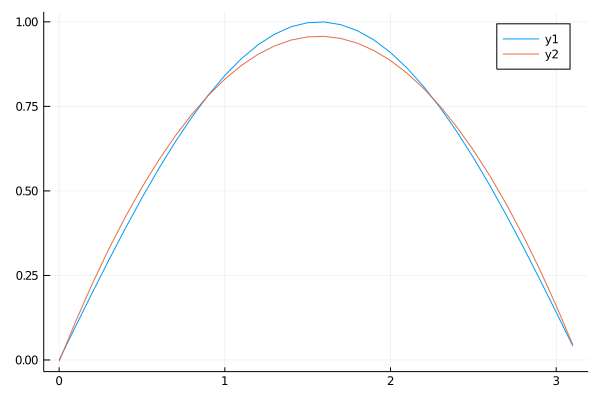

In [75]:
# use this cell to experiment, e.g. determine the parameters for the 
# approximant. But implement your solution in the cell below!

# Generate equispaced nodes
X = 0:0.1:pi
Y = [sin(x) for x = X]

function sinerror(M)
    return sum([(model(M, x) - sin(x))^2 for x = X])
end

function model(M, x)
    len = size(M)[1]
    x_powers = ones(len)
    sol = M[1]*x_powers[1]
    for i = 2:len
        x_powers[i] = x_powers[i-1]*x
        sol += M[i]*x_powers[i]
    end
    return sol
end

# Used a curve fitter in python to come up with an initial "guess"
M0 = [-0.41617576,  1.30745471, -0.04746603]
reverse(M0)
# Using Julia's nlsolver to get a little better ;)
result = nlsolve(sinerror, M0)
plot(X, Y)
Y_model = [model(result.zero, x) for x = X]
plot!(X, Y_model)

# Quick comment: would have used optim but couldn't get it working. Hopefully you can see
# how I _would_ have done it with my little Nlsolver example trying to improve the result 
# slightly


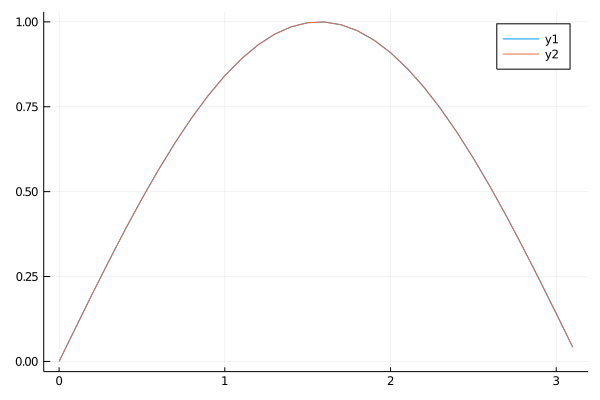

In [76]:
# No reason not to try for a little better -- lets do degree 10

# same deal, used a curve fitter in python get this value
M0 = [-8.76773598e-10, 1.0, 1.35491955e-7, -0.166667424, 5.69261574e-6, 0.00830793389, 5.59007035e-5, -0.000264298844, 4.27621094e-5, -1.16196186e-5, 1.9049719e-6]
plot(X, Y)
Y_model = [model(M0, x) for x = X]
plot!(X, Y_model)

result = nlsolve(sinerror, M0)
plot(X, Y)
Y_model = [model(result.zero, x) for x = X]
plot!(X, Y_model)
# Looks pretty dead on!

In [77]:

function mysin(x::Float64)
    # Start by bringing the result into the "zone" we care about [-pi, pi]
    x = x % (2*pi)
    # Set the multiplier
    mult = 1
    if x > pi
        mult = -1
        x -= pi
    end
    
    if x > pi/2
       x -= 2*(x - pi/2) 
    end
    
    last_x = 1
    sol = -8.76773598e-10 * last_x
    
    last_x *= x
    sol += 1.0 * last_x
    
    last_x *= x
    sol += 1.35491955e-7 * last_x
    
    last_x *= x
    sol += -0.166667424 * last_x
    
    last_x *= x
    sol += 5.69261574e-6 * last_x
    
    last_x *= x
    sol += 0.00830793389 * last_x
    
    last_x *= x
    sol += 5.59007035e-5 * last_x
    
    last_x *= x
    sol += -0.000264298844 * last_x
    
    last_x *= x
    sol += 4.27621094e-5* last_x
    
    last_x *= x
    sol += -1.16196186e-5 * last_x
    
    last_x *= x
    sol += 1.9049719e-6 * last_x
   
    return sol*mult
    
end


mysin (generic function with 1 method)

In [78]:
# BEGIN TEST

println("Correctness")
Random.seed!(23456)
X = range(1e-7, pi/2-1e-7, length=1_000_000)
X += 6e-8 * (rand(1_000_000) .- 0.5)
err = norm(mysin.(X) - sin.(X), Inf)
println("error = $err (should be < 1e-7)")
try println(@test err < 1e-7); catch; end 

println("Timing:")
x = 0.5 + 0.5 * rand()
tsin = @belapsed sin($x)
tmysin = @belapsed mysin($x)
println("Evaluation time ratio = ", tmysin / tsin, "; (should be < 2)")
try println(@test tmysin <= 2 * tsin); catch; end 

# END TEST


Correctness
error = 6.336633662229474e-9 (should be < 1e-7)
Test Passed
Timing:
Evaluation time ratio = 0.005099168732681931; (should be < 2)
Test Passed


### Question 5: Simpson Rule [5+5+5+10]

Consider the quadrature rule  (Simpson rule) 
$$ 
    \int_{-h/2}^{h/2} f(x) \,dx \approx \frac{h}{6} \big( f(-h/2) + 4 f(0) + f(h/2) \big)
$$

(a) We said that we can most quadrature rules can be interpreted as integrating a polynomial interpolant of the integrand. Which polynomial interpolant does the Simpson rule correspond to? (state without proof)

(b) Derive an error bound, assuming that $f \in C^4([a, b])$.  
[Full points for a short proof that gets within a factor 2 of the sharp bound; partial points for a proof that gets the correct order.]

(c) State (without proof) the corresponding estimate for the composite Simpson rule with mesh-size $h$.

(a) Simpson's rule corresponds to a standard polynomial interpolation with $ N=3 $. In other words we are approximating the function on $ [-h/2, h/2] $ as a quadratic. We already know the three points through which we must calculate this quadratic -- they are $(f_-, -h/2)$, $(f_+, h/2)$, and $(f_0, 0)$ where $f_- = f(-h/2)$ and $f_- = f(-h/2)$. Let's calculate what the prefactors will be given these points and the general form 
$$
    f(x) \approx ax^2 + bx + c
$$
We can note right off the bat that $f(0) = f_0 \implies c = f_0$. Next, note that 
$$
    a(-h/2)^2 + b(-h/2) + f_0 = f_- \\
    \implies b = \frac{f_- - a(-h/2)^2 - f_0}{(-h/2)} \\
    b = \frac{2f_0}{h} + \frac{ah}{2} - \frac{2f_-}{h}
$$

Using these values and the final point that we have, we can calculate the following
$$
    f(x) = ax^2 + bx + c \\
    \implies f_+ = \frac{ah^2}{4} + f_0 + \frac{ah^2}{4} - f_- + f_0 \\
    \implies a = \frac{2}{h^2} (f_- + f_+ + 2f_0)
$$

Then we have the polynomial

$$
    f(x) \approx \frac{2}{h^2} (f_- + f_+ + 2f_0) x^2 + \left( \frac{2f_0}{h} + \frac{ah}{2} - \frac{2f_-}{h} \right) x + f_0
$$

(b) I could not work this out.

(c) Since we have the basic Simpson rule established, we can state the composite rule s.t. we have something to implement an algorithm based on. Here it is
$$
    I_S := \sum_{m = 1}^M \left( \frac{(x_m-x_{m-1})}{6} \right) \left(f(x_{m-1}) + 4*f\big( 0.5 (x_{m-1}+x_m) \big) + f(x_{m}) \right)
$$
Where $M$ is the number of nodes we would to have along the function and $x_m$ is the $m$th node.

(d) Using the integral $\int_0^\pi \sin(x) \,dx = 2$ as an example, confirm the convergence rate predicted in (b), numerically. Produce a figure that compares the numerical convergence rate against the predicted rate. 

Ideally, you should first implement a function, e.g., `function simpson(f, a, b, N)` which implements the simpson rule. Then implement a short test (see lectures for inspiration!) which checks that the output of your function converges with the predicted rate to the analytic value.

    I think this makes sense. It seems like the predicted error follows the error calculated fairly well. It seems that I am still off by some constant but not sure what that is coming from. Notably we hit machine precision at N = 10^3.5 ish.



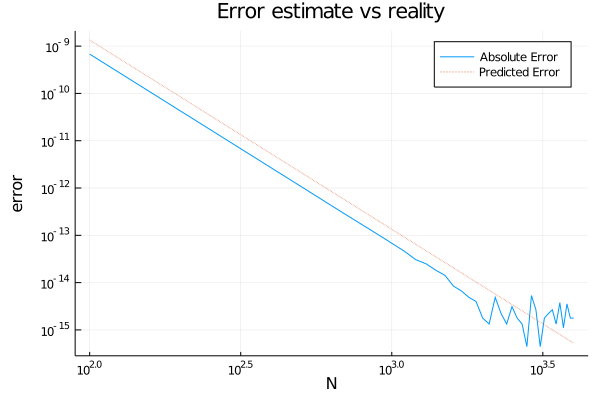

In [118]:
# solution part (d) 

function simpson(f, a, b, N)
    I = 0
    
    h = (b - a)/N
    for m = 1:N
        I += h/6 * (f(a + (m-1)*h) + 4*f(a + m*h - 0.5h) + f(a + m*h))
    end
    
    return I
end

# How to check if this is any good? Lets plot log|2 - simpson_output| vs N
Ns = 100:100:4000
err = [abs(2 - simpson(sin, 0, pi, n)) for n = Ns]
plot(Ns, err, xaxis=:log, yaxis=:log, label = "Absolute Error")

# Also plot the predicted error (btw we know O(f^(iv)) = 1 so don't worry about it)
# We can note the error here will be N * (1/2280) * h^5 where N = b-a/h \implies error is b-a * (1/2280) * h^4 
# 1/2280 is from class, I did not derive it ;)
pred_err = [pi*(1/2280)*(pi/n)^4 for n = Ns]
plot!(Ns, pred_err, xaxis=:log, yaxis=:log, linestyle=:dot, label = "Predicted Error")

println("""
    I think this makes sense. It seems like the predicted error follows the error calculated fairly well. It seems that I am still off by some constant but not sure what that is coming from. Notably we hit machine precision at N = 10^3.5 ish.
""")
title!("Error estimate vs reality")
ylabel!("error")
xlabel!("N")

## Question 6 [5+5+5+5] : integrate some functions

Integrate each of the following functions numerically. For each function you should 
* use an integrator that you implemented yourself (simpson?)
* use the `Cubature.jl` package. 
Store the solutions in the variables `I_x` (your own method) and `Icub_x` (the `Cubature.jl` solution) where `x` is `a`, `b`, ...; e.g. 
```julia
f_a = x -> exp(-x^2)
I_a = my_method(f_a, ...) 
Icub_a, err_a = hquadrature(f_a, ...)
```

(a) $f_a(x) = e^{-x^2}, x \in [0, 1]$

(b) $f_b(x) = x \log(x), x \in [0, 1]$ 

(c) $f_c(x) = \sqrt{x} \log(x), x \in [0, 1]$ 

(d) $f_d(x) = \sqrt{x} \exp(- 0.1 x), x \in [1, \infty]$

I encourage you to use brute-force rather than get too clever about manually resolving the singularities. Let the computer do the work for you.

In [146]:
using Cubature 

# (a) 
fa = x -> exp(-x^2)
Icub_a, err_a = hquadrature(fa, 0, 1)
I_a = simpson(fa, 0, 1, 1000)
@show Icub_a - I_a

#b
fb = x -> x*log(x)
Icub_b, err_b = hquadrature(fb, 0, 1)
I_b = simpson(fb, eps(Float64), 1, 1000)
@show Icub_b - I_b

#c
fc = x -> sqrt(x)*log(x)
Icub_c, err_c = hquadrature(fc, 0, 1)
I_c = simpson(fc, eps(Float64), 1, 10000)
@show Icub_c - I_c

#d
# Quickly checking where machine precison in f(x)
fd = x -> sqrt(x)*exp(-0.1*x)
X = 1:1:400
Y = [fd(x) for x = X]
plot(X, Y, xaxis=:log, yaxis=:log)
# Plot shows me that this happens around 400
# No point integrating past there

Icub_d, err_d = hquadrature(fd, 0, 400)
I_d = simpson(fd, 0, 400, 500000)
@show Icub_d - I_d

Icub_a - I_a = -2.220446049250313e-16
Icub_b - I_b = -1.9255481681357267e-8
Icub_c - I_c = -3.8210927505444303e-7
Icub_d - I_d = 6.495975739539972e-7


6.495975739539972e-7